## 證交所 資料

In [181]:
import requests
from bs4 import BeautifulSoup
import datetime
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import json
from functools import reduce

In [237]:
# 全域設定

# 顯示全部的行列
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

# 欲查詢日期
search_date = datetime.date(2021,7,12)

In [168]:
def get_twse_price(date) -> pd.DataFrame:
    try:
        year = date.year
        month = date.month
        day = date.day
        new_date = f"{year}{month:02}{day:02}"  # 生成符合 url query 的日期字串
        r = requests.post(f"https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date={new_date}&type=ALL")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text.replace("=", "")), 
            header=["證券代號" in l for l in r.text.split("\n")].index(True)-1)
        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["證券名稱"] = df["證券名稱"].astype(str)
        df["證券代號"] = df["證券代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["證券名稱"] = df["證券名稱"].str.strip()
        df["證券代號"] = df["證券代號"].str.strip()
        # 去除多餘欄位
        df = df.drop(["Unnamed: 16"], axis=1, inplace=False)
        # 取出上市股票（4碼）
        df = df[(df["證券代號"].str.len() == 4) & (df["證券代號"].str[:2] != "00")]
        # 合併漲跌數據
        df["漲跌"] = [str(x) + str(y) for x, y in zip(df["漲跌(+/-)"], df["漲跌價差"])]
        # 僅保留所需欄位
        df = df.drop(["成交筆數", "成交金額", "最後揭示買價", "最後揭示買量", "最後揭示賣價", "最後揭示賣量", "本益比", "漲跌(+/-)", "漲跌價差"], axis=1, inplace=False)
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["證券代號", "證券名稱"] else s)
        # 重新命名表頭
        df.columns = ["代號", "名稱", "成交股數", "開盤", "最高", "最低", "收盤", "漲跌"]
        # 重新排序表頭
        df = df[["代號", "名稱", "收盤", "漲跌", "開盤", "最高", "最低", "成交股數"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（twse）
        df["股票類型"] = "twse"
        return df
    except:
        return pd.DataFrame(columns=["代號", "名稱", "收盤", "漲跌", "開盤", "最高", "最低", "成交股數", "股票類型"])


In [169]:
get_twse_price(search_date)

,代號,名稱,收盤,漲跌,開盤,最高,最低,成交股數,股票類型
0,1101,台泥,52.2,0.2,52.2,52.4,51.8,26725789,twse
1,1102,亞泥,52.7,-0.1,52.9,53.0,52.5,11953702,twse
...,...,...,...,...,...,...,...,...,...
954,9955,佳龍,18.6,0.1,18.8,18.8,18.5,178052,twse
955,9958,世紀鋼,129.0,0.0,131.5,132.0,129.0,2220932,twse


In [170]:
def get_twse_fundamental(date) -> pd.DataFrame:
    try:
        year = date.year
        month = date.month
        day = date.day
        new_date = f"{year}{month:02}{day:02}"  # 生成符合 url query 的日期字串
        r = requests.get(f"https://www.twse.com.tw/exchangeReport/BWIBBU_d?response=csv&date={new_date}&selectType=ALL")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text.replace("=", "")), 
            header=1)
        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["證券名稱"] = df["證券名稱"].astype(str)
        df["證券代號"] = df["證券代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["證券名稱"] = df["證券名稱"].str.strip()
        df["證券代號"] = df["證券代號"].str.strip()
        # 去除多餘欄位
        df = df.drop(["Unnamed: 7", "財報年/季"], axis=1, inplace=False)
        # 取出上市股票（4碼）
        df = df[(df["證券代號"].str.len() == 4) & (df["證券代號"].str[:2] != "00")]
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["證券代號", "證券名稱"] else s)
        # 重新命名表頭
        df = df.rename(columns={"證券代號": "代號", "證券名稱": "名稱"})
        # 重新排序表頭
        df = df[["代號", "名稱", "本益比", "股利年度", "殖利率(%)", "股價淨值比"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（twse）
        df["股票類型"] = "twse"
        return df
    except:
        return pd.DataFrame(columns=["代號", "名稱", "本益比", "股利年度", "殖利率(%)", "股價淨值比", "股票類型"])

In [171]:
get_twse_fundamental(search_date)

,代號,名稱,本益比,股利年度,殖利率(%),股價淨值比,股票類型


In [172]:
def get_twse_margin_trading(date) -> pd.DataFrame:
    try:
        year = date.year
        month = date.month
        day = date.day
        new_date = f"{year}{month:02}{day:02}"  # 生成符合 url query 的日期字串
        r = requests.get(f"https://www.twse.com.tw/exchangeReport/MI_MARGN?response=csv&date={new_date}&selectType=ALL")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text.replace("=", "")), header=7)
        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["股票名稱"] = df["股票名稱"].astype(str)
        df["股票代號"] = df["股票代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["股票名稱"] = df["股票名稱"].str.strip()
        df["股票代號"] = df["股票代號"].str.strip()
        # 去除多餘欄位
        df = df.drop(["現金償還", "限額", "現券償還", "限額.1", "註記", "Unnamed: 16"], axis=1, inplace=False)
        # 取出上市股票（4碼）
        df = df[(df["股票代號"].str.len() == 4) & (df["股票代號"].str[:2] != "00")]
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["股票代號", "股票名稱"] else s)
        # 重新命名表頭
        df = df.rename(columns={"股票代號": "代號", "股票名稱": "名稱", "買進": "融資買進", "賣出": "融資賣出",
                               "前日餘額": "融資前日餘額", "今日餘額": "融資今日餘額", "買進.1": "融券買進", "賣出.1": "融券賣出",
                               "前日餘額.1": "融券前日餘額", "今日餘額.1": "融券今日餘額"})
        # 計算指標
        df["融資變化量"] = df["融資今日餘額"] - df["融資前日餘額"]
        df["融券變化量"] = df["融券今日餘額"] - df["融券前日餘額"]
        df["券資比(%)"] = round((df["融券今日餘額"] / df["融資今日餘額"]) * 100, 2)  # 注意分母是否為0
        # 重新排序表頭
        df = df[["代號", "名稱", "融資買進", "融資賣出", "融資前日餘額", "融資今日餘額", 
                                     "融券買進", "融券賣出", "融券前日餘額", "融券今日餘額", "資券互抵", "融資變化量", "融券變化量", "券資比(%)"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（twse）
        df["股票類型"] = "twse"
        return df
    except:
        return pd.DataFrame(columns=["代號", "名稱", "融資買進", "融資賣出", "融資前日餘額", "融資今日餘額", 
                                     "融券買進", "融券賣出", "融券前日餘額", "融券今日餘額", "資券互抵", "融資變化量", "融券變化量", "券資比(%)", "股票類型"])


In [173]:
get_twse_margin_trading(search_date)

,代號,名稱,融資買進,融資賣出,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券前日餘額,融券今日餘額,資券互抵,融資變化量,融券變化量,券資比(%),股票類型


In [174]:
def get_twse_institutional(date) -> pd.DataFrame:
    try:
        year = date.year
        month = date.month
        day = date.day
        new_date = f"{year}{month:02}{day:02}"  # 生成符合 url query 的日期字串
        r = requests.get(f"https://www.twse.com.tw/fund/T86?response=csv&date={new_date}&selectType=ALL")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text.replace("=", "")), 
            header=1)
        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["證券名稱"] = df["證券名稱"].astype(str)
        df["證券代號"] = df["證券代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["證券名稱"] = df["證券名稱"].str.strip()
        df["證券代號"] = df["證券代號"].str.strip()
        # 去除多餘欄位
        df = df[["證券代號", "證券名稱", "外陸資買賣超股數(不含外資自營商)", "投信買賣超股數", "自營商買賣超股數", "三大法人買賣超股數"]]
        # 取出上市股票（4碼）
        df = df[(df["證券代號"].str.len() == 4) & (df["證券代號"].str[:2] != "00")]
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["證券代號", "證券名稱"] else s)
        # 重新命名表頭
        df = df.rename(columns={"證券名稱": "名稱", "證券代號": "代號", "外陸資買賣超股數(不含外資自營商)": "外資買賣超股數"})
        # 重新排序表頭
        df = df[["代號", "名稱", "外資買賣超股數", "投信買賣超股數", "自營商買賣超股數", "三大法人買賣超股數"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（twse）
        df["股票類型"] = "twse"
        return df
    except:
        return pd.DataFrame(columns=["代號", "名稱", "外資買賣超股數", "投信買賣超股數", "自營商買賣超股數", "三大法人買賣超股數", "股票類型"])
    

In [175]:
get_twse_institutional(search_date)

,代號,名稱,外資買賣超股數,投信買賣超股數,自營商買賣超股數,三大法人買賣超股數,股票類型
0,1101,台泥,-3417450,-81000,89000,-3409450,twse
1,1102,亞泥,-1620600,-72000,-143000,-1835600,twse
...,...,...,...,...,...,...,...
916,9955,佳龍,-17000,0,0,-17000,twse
917,9958,世紀鋼,10083,405000,-227000,188083,twse


In [176]:
def get_twse_hold_percentage(date) -> pd.DataFrame:
    try:
        year = date.year
        month = date.month
        day = date.day
        new_date = f"{year}{month:02}{day:02}"  # 生成符合 url query 的日期字串
        r = requests.get(f"https://www.twse.com.tw/fund/MI_QFIIS?response=csv&date={new_date}&selectType=ALLBUT0999")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text.replace("=", "")), 
            header=1)
        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["證券名稱"] = df["證券名稱"].astype(str)
        df["證券代號"] = df["證券代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["證券名稱"] = df["證券名稱"].str.strip()
        df["證券代號"] = df["證券代號"].str.strip()
        # 去除多餘欄位
        df = df[["證券代號", "證券名稱", "全體外資及陸資持股比率"]]
        # 取出上市股票（4碼）
        df = df[(df["證券代號"].str.len() == 4) & (df["證券代號"].str[:2] != "00")]
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["證券代號", "證券名稱"] else s)
        # 重新命名表頭
        df = df.rename(columns={"證券名稱": "名稱", "證券代號": "代號", "全體外資及陸資持股比率": "外資持股比率(%)"})
        # 重新排序表頭
        df = df[["代號", "名稱", "外資持股比率(%)"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（twse）
        df["股票類型"] = "twse"
        return df
    except:
        return pd.DataFrame(columns=["代號", "名稱", "外資持股比率(%)", "股票類型"])
    

In [177]:
get_twse_hold_percentage(search_date)

,代號,名稱,外資持股比率(%),股票類型


In [178]:
def get_twse_final(date):
    _start_time = time.time()
    twse_price_df = get_twse_price(date)
    twse_fundamental_df = get_twse_fundamental(date)
    twse_margin_trading_df = get_twse_margin_trading(date)
    twse_institutional_df = get_twse_institutional(date)
    twse_hold_percentage_df = get_twse_hold_percentage(date)
    try:
        df = pd.merge(twse_price_df, twse_fundamental_df, how="left", on=["代號", "名稱", "股票類型"])
        df = pd.merge(df, twse_margin_trading_df, how="left", on=["代號", "名稱", "股票類型"])
        df = pd.merge(df, twse_institutional_df, how="left", on=["代號", "名稱", "股票類型"])
        df = pd.merge(df, twse_hold_percentage_df, how="left", on=["代號", "名稱", "股票類型"])
        # 沒有三大法人買賣超的補上0
#         df[['外資買賣超股數', '投信買賣超股數', "自營商買賣超股數", "三大法人買賣超股數"]] = df[['外資買賣超股數', '投信買賣超股數', "自營商買賣超股數", "三大法人買賣超股數"]].fillna(value=0)
        # 外資沒有持股的補上0
#         df[["外資持股比率(%)"]] = df[["外資持股比率(%)"]].fillna(value=0)
        df = df.set_index("代號")
        _end_time = time.time()
        _spent_time = _end_time - _start_time
        print(f"取得上市資料表花費時間: {datetime.timedelta(seconds=int(_spent_time))}")
        return df
    except:
        print("有Bug！")
        return None

In [179]:
get_twse_final(search_date)

取得上市資料表花費時間: 0:00:06


,名稱,收盤,漲跌,開盤,最高,最低,成交股數,股票類型,本益比,股利年度,殖利率(%),股價淨值比,融資買進,融資賣出,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券前日餘額,融券今日餘額,資券互抵,融資變化量,融券變化量,券資比(%),外資買賣超股數,投信買賣超股數,自營商買賣超股數,三大法人買賣超股數,外資持股比率(%)
代號,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1101,台泥,52.2,0.2,52.2,52.4,51.8,26725789,twse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3417450.0,-81000.0,89000.0,-3409450.0,NaN
1102,亞泥,52.7,-0.1,52.9,53.0,52.5,11953702,twse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1620600.0,-72000.0,-143000.0,-1835600.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,佳龍,18.6,0.1,18.8,18.8,18.5,178052,twse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17000.0,0.0,0.0,-17000.0,NaN
9958,世紀鋼,129.0,0.0,131.5,132.0,129.0,2220932,twse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10083.0,405000.0,-227000.0,188083.0,NaN


## 櫃買中心 資料

In [182]:
def get_tpex_price(date) -> pd.DataFrame:
    try:
        year = date.year - 1911  # 轉換成民國
        month = date.month
        day = date.day
        new_date = f"{year}/{month:02}/{day:02}"  # 生成符合 url query 的日期字串
        r = requests.get(f"https://www.tpex.org.tw/web/stock/aftertrading/otc_quotes_no1430/stk_wn1430_result.php?l=zh-tw&o=csv&d={new_date}&se=AL&s=0,asc,0")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text), header=3)
        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["名稱"] = df["名稱"].astype(str)
        df["代號"] = df["代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["名稱"] = df["名稱"].str.strip()
        df["代號"] = df["代號"].str.strip()
        # 僅保留所需欄位
        df = df.drop(df.columns[8:], axis=1, inplace=False)
        # 取出上櫃股票（4碼）
        df = df[(df["代號"].str.len() == 4) & (df["代號"].str[:2] != "00")]
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["代號", "名稱"] else s)
        # 重新排序表頭
        df = df[["代號", "名稱", "收盤", "漲跌", "開盤", "最高", "最低", "成交股數"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（tpex）
        df["股票類型"] = "tpex"
        return df
    except:
        return pd.DataFrame(columns=['代號', '名稱', '收盤', '漲跌', '開盤', '最高', '最低', '成交股數', '股票類型'])
    

In [183]:
get_tpex_price(search_date)

,代號,名稱,收盤,漲跌,開盤,最高,最低,成交股數,股票類型
0,1240,茂生農經,55.30,0.10,55.40,55.40,55.10,41000,tpex
1,1258,其祥-KY,16.90,0.55,16.75,17.00,16.25,114000,tpex
...,...,...,...,...,...,...,...,...,...
783,9960,邁達康,27.85,0.40,27.50,27.85,27.50,43000,tpex
784,9962,有益,19.90,1.45,20.25,20.25,18.70,11024000,tpex


In [184]:
def get_tpex_fundamental(date) -> pd.DataFrame:
    try:
        year = date.year - 1911  # 轉換成民國
        month = date.month
        day = date.day
        new_date = f"{year}/{month:02}/{day:02}"  # 生成符合 url query 的日期字串
        r = requests.get(f"https://www.tpex.org.tw/web/stock/aftertrading/peratio_analysis/pera_result.php?l=zh-tw&o=csv&charset=UTF-8&d={new_date}&c=&s=0,asc")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text), header=3)

        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["名稱"] = df["名稱"].astype(str)
        df["股票代號"] = df["股票代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["名稱"] = df["名稱"].str.strip()
        df["股票代號"] = df["股票代號"].str.strip()
        # 去除多餘欄位
        df = df.drop(["每股股利",], axis=1, inplace=False)
        # 取出上櫃股票（4碼）
        df = df[(df["股票代號"].str.len() == 4) & (df["股票代號"].str[:2] != "00")]
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["股票代號", "名稱"] else s)
        # 將不同表格的「股票代號」欄位名稱都統一為「代號」
        df = df.rename(columns={"股票代號": "代號"})
        # 重新排序表頭
        df = df[["代號", "名稱", "本益比", "股利年度", "殖利率(%)", "股價淨值比"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（tpex）
        df["股票類型"] = "tpex"
        return df
    except:
        return pd.DataFrame(columns=['代號', '名稱', '本益比', '股利年度', '殖利率(%)', '股價淨值比', '股票類型'])
    

In [185]:
get_tpex_fundamental(search_date)

,代號,名稱,本益比,股利年度,殖利率(%),股價淨值比,股票類型


In [186]:
def get_tpex_margin_trading(date) -> pd.DataFrame:
    try:
        year = date.year - 1911  # 轉換成民國
        month = date.month
        day = date.day
        new_date = f"{year}/{month:02}/{day:02}"  # 生成符合 url query 的日期字串
        r = requests.get(f"https://www.tpex.org.tw/web/stock/margin_trading/margin_balance/margin_bal_result.php?l=zh-tw&o=csv&charset=UTF-8&d={new_date}&s=0,asc")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text), header=2)
        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["名稱"] = df["名稱"].astype(str)
        df["代號"] = df["代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["名稱"] = df["名稱"].str.strip()
        df["代號"] = df["代號"].str.strip()
        # 去除多餘欄位
        df = df.drop(["現償", "資屬證金", "資使用率(%)", "資限額", "券償", "券屬證金", "券使用率(%)", "券限額", "備註"], axis=1, inplace=False)
        # 取出上櫃股票（4碼）
        df = df[(df["代號"].str.len() == 4) & (df["代號"].str[:2] != "00")]
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["代號", "名稱"] else s)
        # 重新命名表頭
        df = df.rename(columns={"資買": "融資買進", "資賣": "融資賣出",
                               "前資餘額(張)": "融資前日餘額", "資餘額": "融資今日餘額", "券買": "融券買進", "券賣": "融券賣出",
                               "前券餘額(張)": "融券前日餘額", "券餘額": "融券今日餘額", "資券相抵(張)": "資券互抵"})
        # 計算指標
        df["融資變化量"] = df["融資今日餘額"] - df["融資前日餘額"]
        df["融券變化量"] = df["融券今日餘額"] - df["融券前日餘額"]
        df["券資比(%)"] = round((df["融券今日餘額"] / df["融資今日餘額"]) * 100, 2)  # 注意分母是否為0
        # 重新排序表頭
        df = df[["代號", "名稱", "融資買進", "融資賣出", "融資前日餘額", "融資今日餘額", 
                                     "融券買進", "融券賣出", "融券前日餘額", "融券今日餘額", "資券互抵", "融資變化量", "融券變化量", "券資比(%)"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（tpex）
        df["股票類型"] = "tpex"
        return df
    except:
        return pd.DataFrame(columns=["代號", "名稱", "融資買進", "融資賣出", "融資前日餘額", "融資今日餘額", 
                                     "融券買進", "融券賣出", "融券前日餘額", "融券今日餘額", "資券互抵", "融資變化量", "融券變化量", "券資比(%)", "股票類型"])


In [187]:
get_tpex_margin_trading(search_date)

,代號,名稱,融資買進,融資賣出,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券前日餘額,融券今日餘額,資券互抵,融資變化量,融券變化量,券資比(%),股票類型


In [188]:
def get_tpex_institutional(date) -> pd.DataFrame:
    try:
        year = date.year - 1911  # 轉換成民國
        month = date.month
        day = date.day
        new_date = f"{year}/{month:02}/{day:02}"  # 生成符合 url query 的日期字串
        r = requests.get(f"https://www.tpex.org.tw/web/stock/3insti/daily_trade/3itrade_hedge_result.php?l=zh-tw&o=csv&se=AL&t=D&d={new_date}&s=0,asc")
        # 整理資料，變成表格
        df = pd.read_csv(StringIO(r.text), header=1)
        # 去除各個欄位名稱後方的多餘空格
        df.columns = [each.strip() for each in df.columns]
        # 更新名稱與代號欄位的資料型態
        df["名稱"] = df["名稱"].astype(str)
        df["代號"] = df["代號"].astype(str)
        # 去除名稱與代號的前後空格
        df["名稱"] = df["名稱"].str.strip()
        df["代號"] = df["代號"].str.strip()
        # 去除多餘欄位
        df = df[["代號", "名稱", "外資及陸資(不含外資自營商)-買賣超股數", "投信-買賣超股數", "自營商-買賣超股數", "三大法人買賣超股數合計"]]
        # 取出上櫃股票（4碼）
        df = df[(df["代號"].str.len() == 4) & (df["代號"].str[:2] != "00")]
        # 字串轉數字，去除逗號
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["代號", "名稱"] else s)
        # 重新命名表頭
        df = df.rename(columns={"外資及陸資(不含外資自營商)-買賣超股數": "外資買賣超股數", "投信-買賣超股數": "投信買賣超股數", 
                                "自營商-買賣超股數": "自營商買賣超股數", "三大法人買賣超股數合計": "三大法人買賣超股數"})
        # 重新排序表頭
        df = df[["代號", "名稱", "外資買賣超股數", "投信買賣超股數", "自營商買賣超股數", "三大法人買賣超股數"]]
        # 重新照股票代號排序
        df = df.sort_values(by=["代號"])
        # 重置 index
        df = df.reset_index(drop=True)
        # 新增類別（tpex）
        df["股票類型"] = "tpex"
        return df
    except:
        return pd.DataFrame(columns=['代號', '名稱', '外資買賣超股數', '投信買賣超股數', '自營商買賣超股數', '三大法人買賣超股數', '股票類型'])
    

In [189]:
get_tpex_institutional(search_date)

,代號,名稱,外資買賣超股數,投信買賣超股數,自營商買賣超股數,三大法人買賣超股數,股票類型
0,1258,其祥-KY,0,0,-1000,-1000,tpex
1,1259,安心,0,0,-3,-3,tpex
...,...,...,...,...,...,...,...
636,9960,邁達康,6000,0,0,6000,tpex
637,9962,有益,39000,0,0,39000,tpex


In [190]:
def get_tpex_hold_percentage(date) -> pd.DataFrame:
    year = date.year
    month = date.month
    day = date.day
    # 生成符合 url query 的日期字串
    data = {"years": f"{year}", "months": f"{month:02}", "days": f"{day:02}", "bcode": "", "step": "2"}
    r = requests.post("https://mops.twse.com.tw/server-java/t13sa150_otc", data=data)
    # 解決編碼亂碼問題（在網頁的 console 執行 document.characterSet 查看編碼）
    # Console 可以看很多資訊（function, Encoding, Url...）
    r.encoding = "Big5"
    soup = BeautifulSoup(r.text, "html.parser")
    data = soup.find_all("td")
    hold_percentage_list = [[data[x].text, data[x+1].text, data[x+6].text] for x in range(0, len(data), 11)]
    df = pd.DataFrame(hold_percentage_list, columns=["代號", "名稱", "外資持股比率(%)"])
    # 去除各個欄位名稱後方的多餘空格
    df.columns = [each.strip() for each in df.columns]
    # 更新名稱與代號欄位的資料型態
    df["名稱"] = df["名稱"].astype(str)
    df["代號"] = df["代號"].astype(str)
    # 去除名稱與代號的前後空格
    df["名稱"] = df["名稱"].str.strip()
    df["代號"] = df["代號"].str.strip()
    # 取出上櫃股票（4碼）
    df = df[(df["代號"].str.len() == 4) & (df["代號"].str[:2] != "00") & (df["代號"].str.isdigit())]
    # 字串轉數字，去除逗號
    df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["代號", "名稱"] else s)
    # 重新排序表頭
    df = df[["代號", "名稱", "外資持股比率(%)"]]
    # 重新照股票代號排序
    df = df.sort_values(by=["代號"])
    # 重置 index
    df = df.reset_index(drop=True)
    # 新增類別（tpex）
    df["股票類型"] = "tpex"
    return df

In [191]:
get_tpex_hold_percentage(search_date)

,代號,名稱,外資持股比率(%),股票類型


In [192]:
def get_tpex_final(date):
    _start_time = time.time()
    tpex_price_df = get_tpex_price(date)
    tpex_fundamental_df = get_tpex_fundamental(date)
    tpex_margin_trading_df = get_tpex_margin_trading(date)
    tpex_institutional = get_tpex_institutional(date)
    tpex_hold_percentage_df = get_tpex_hold_percentage(date)
    try:
        df = pd.merge(tpex_price_df, tpex_fundamental_df, how="left", on=["代號", "名稱", "股票類型"])
        df = pd.merge(df, tpex_margin_trading_df, how="left", on=["代號", "名稱", "股票類型"])
        df = pd.merge(df, tpex_institutional, how="left", on=["代號", "名稱", "股票類型"])
        df = pd.merge(df, tpex_hold_percentage_df, how="left", on=["代號", "名稱", "股票類型"])
        # 沒有三大法人買賣超的補上0
#         df[['外資買賣超股數', '投信買賣超股數', "自營商買賣超股數", "三大法人買賣超股數"]] = df[['外資買賣超股數', '投信買賣超股數', "自營商買賣超股數", "三大法人買賣超股數"]].fillna(value=0)
        # 外資沒有持股的補上0
#         df[["外資持股比率(%)"]] = df[["外資持股比率(%)"]].fillna(value=0)
        df = df.set_index("代號")
        _end_time = time.time()
        _spent_time = _end_time - _start_time
        print(f"取得上櫃資料表花費時間: {datetime.timedelta(seconds=int(_spent_time))}")
        return df
    except:
        print("有Bug！")
        return None

In [193]:
get_tpex_final(search_date)

取得上櫃資料表花費時間: 0:00:16


,名稱,收盤,漲跌,開盤,最高,最低,成交股數,股票類型,本益比,股利年度,殖利率(%),股價淨值比,融資買進,融資賣出,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券前日餘額,融券今日餘額,資券互抵,融資變化量,融券變化量,券資比(%),外資買賣超股數,投信買賣超股數,自營商買賣超股數,三大法人買賣超股數,外資持股比率(%)
代號,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1240,茂生農經,55.30,0.10,55.40,55.40,55.10,41000,tpex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,其祥-KY,16.90,0.55,16.75,17.00,16.25,114000,tpex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-1000.0,-1000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,邁達康,27.85,0.40,27.50,27.85,27.50,43000,tpex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.0,0.0,0.0,6000.0,NaN
9962,有益,19.90,1.45,20.25,20.25,18.70,11024000,tpex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39000.0,0.0,0.0,39000.0,NaN


## FinMind 取得產業別

In [194]:
def get_industry_category() -> pd.DataFrame:
    parameter = {
        "dataset": "TaiwanStockInfo",
        "token": "", # 參考登入，獲取金鑰
    }
    r = requests.get("https://api.finmindtrade.com/api/v4/data", params=parameter)
    data = r.json()
    df = pd.DataFrame(data["data"])
    # 去除各個欄位名稱後方的多餘空格
    df.columns = [each.strip() for each in df.columns]
    # 重新命名欄位
    df = df.rename(columns={"industry_category": "產業別", "stock_id": "代號", "stock_name": "名稱", "type": "股票類型"})
    # 更新名稱與代號欄位的資料型態
    df["名稱"] = df["名稱"].astype(str)
    df["代號"] = df["代號"].astype(str)
    # 去除名稱與代號的前後空格
    df["名稱"] = df["名稱"].str.strip()
    df["代號"] = df["代號"].str.strip()
    # 取出股票（4碼）
    df = df[(df["代號"].str.len() == 4) & (df["代號"].str[:2] != "00") & (df["代號"].str.isdigit())]
    # 只保留所需欄位
    df = df[["代號", "名稱", "產業別", "股票類型"]]
    df = df.set_index("代號")
    return df

In [195]:
industry_category_df = get_industry_category()
industry_category_df

,名稱,產業別,股票類型
代號,,,
1101,台泥,水泥工業,twse
1102,亞泥,水泥工業,twse
...,...,...,...
9960,邁達康,貿易百貨,tpex
9962,有益,鋼鐵工業,tpex


In [196]:
industry_category_df["產業別"].unique()

array(['水泥工業', '其他', '食品工業', '電器電纜', '農業科技業', '觀光事業', '塑膠工業', '建材營造',
       '汽車工業', '電子零組件類', '紡織纖維', '貿易百貨', '電子工業', '電子零組件業', '電機機械',
       '生技醫療類', '電腦及週邊類', '化學生技醫療', '生技醫療業', '化學工業', '其他電子類', '玻璃陶瓷',
       '造紙工業', '鋼鐵工業', '橡膠工業', '航運業', '電腦及週邊設備業', '半導體業', '其他電子業',
       '通信網路業', '光電業', '電子通路業', '資訊服務業', '油電燃氣業', '金融保險', '文化創意業', '光電業類',
       '半導體類', '通信網路類', '電子商務業', '資訊服務類', '電子通路類', '金融業', '油電燃氣類', '存託憑證'],
      dtype=object)

In [197]:
industry_category_df[industry_category_df["名稱"] == "光寶科"]

,名稱,產業別,股票類型
代號,,,
2301,光寶科,電子工業,twse
2301,光寶科,電腦及週邊設備業,twse


## 取得上市上櫃 MoM 與 YoY

In [198]:
def get_mom_yoy() -> pd.DataFrame:
    headers = {
        "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
    }
    r = requests.get("https://stock.wespai.com/p/44850", headers=headers)
    soup = BeautifulSoup(r.text, "html.parser")
    data = soup.find_all("td")
    mom_yoy_list = [[data[x].text, data[x+1].select_one("a").text, data[x+3].text, data[x+4].text, data[x+5].text] for x in range(0, len(data), 6)]
    df = pd.DataFrame(mom_yoy_list, columns=["代號", "名稱", "(月)營收月增率(%)", "(月)營收年增率(%)", "(月)累積營收年增率(%)"])
    # 字串轉數字，去除逗號
    df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce') if s.name not in ["代號", "名稱"] else s)
    # 更新名稱與代號欄位的資料型態
    df["名稱"] = df["名稱"].astype(str)
    df["代號"] = df["代號"].astype(str)
    # 去除名稱與代號的前後空格
    df["名稱"] = df["名稱"].str.strip()
    df["代號"] = df["代號"].str.strip()
    df = df.set_index("代號")
    df = df.sort_index()
    return df

In [199]:
get_mom_yoy()

,名稱,(月)營收月增率(%),(月)營收年增率(%),(月)累積營收年增率(%)
代號,,,,
1101,台泥,1.66,-0.40,5.13
1102,亞泥,-1.81,7.04,23.41
...,...,...,...,...
9960,邁達康,-17.29,56.94,126.00
9962,有益,34.45,-16.65,-22.38


## 取得技術指標

In [200]:
def calculate_date_from_milliseconds(input_milliseconds: int) -> datetime.date:
    current_year = datetime.datetime.now().year
    current_year_beginning = datetime.date(current_year, 1, 1)
    time_delta_days = datetime.timedelta(days=datetime.timedelta(seconds=input_milliseconds/1000 - 13*86400).days % 365)
    final_date = current_year_beginning + time_delta_days
    return final_date

In [201]:
def make_technical_pretty_list(indicator_list: list) -> list:
    return [[calculate_date_from_milliseconds(t), i] for t, i in indicator_list]

In [202]:
def make_daily_k_pretty_list(daily_k_list: list) -> list:
    new_daily_k_list = list()
    for each in daily_k_list:
        single_time = calculate_date_from_milliseconds(each[0])
        single_k_dict = {
            "開盤": each[1],
            "最高": each[2],
            "最低": each[3],
            "收盤": each[4],
        }
        new_daily_k_list.append([single_time, single_k_dict])
    return new_daily_k_list

In [204]:
def get_technical_indicators_from_stock_id(stock_id: str) -> dict:
    try:
        r = requests.get(f"https://histock.tw/stock/chip/chartdata.aspx?no={stock_id}&days=80&m=dailyk,close,volume,mean5,mean10,mean20,mean60,mean120,mean5volume,mean20volume,k9,d9,rsi6,rsi12,dif,macd,osc")
        technical_data = r.json()
        k9 = make_technical_pretty_list(json.loads(technical_data["K9"]))
        d9 = make_technical_pretty_list(json.loads(technical_data["D9"]))
        dif = make_technical_pretty_list(json.loads(technical_data["DIF"]))
        macd = make_technical_pretty_list(json.loads(technical_data["MACD"]))
        osc = make_technical_pretty_list(json.loads(technical_data["OSC"]))
        mean5 = make_technical_pretty_list(json.loads(technical_data["Mean5"]))
        mean10 = make_technical_pretty_list(json.loads(technical_data["Mean10"]))
        mean20 = make_technical_pretty_list(json.loads(technical_data["Mean20"]))
        mean60 = make_technical_pretty_list(json.loads(technical_data["Mean60"]))
        volume = make_technical_pretty_list(json.loads(technical_data["Volume"]))
        daily_k = make_daily_k_pretty_list(json.loads(technical_data["DailyK"]))
        return {"k9": k9, "d9": d9, "dif": dif, "macd": macd, "osc": osc,
                "mean5": mean5, "mean10": mean10, "mean20": mean20, "mean60": mean60,
                "volume": volume, "daily_k": daily_k}
    except:
        return None

In [205]:
# 取得技術指標
data = get_technical_indicators_from_stock_id(6168)

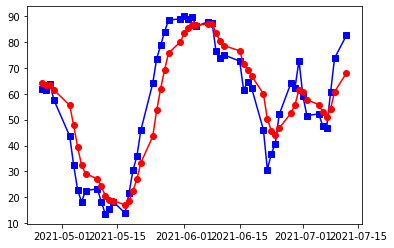

In [206]:
# 繪製技術線圖
plt.plot([x[0] for x in data["k9"]], [x[1] for x in data["k9"]],'s-',color = 'b', label="k")
plt.plot([x[0] for x in data["d9"]], [x[1] for x in data["d9"]],'o-',color = 'r', label="d")
plt.show()

In [208]:
# 每日 K 線
# data["daily_k"]

In [210]:
def get_technical_indicators(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    _start_time = time.time()
    new_column_list = ["k9", "d9", "dif", "macd", "osc", "mean5", "mean10", "mean20", "mean60", "volume", "daily_k"]
    df[new_column_list] = None
    df[["k9", "d9", "dif", "macd", "osc", "mean5", "mean10", "mean20", "mean60", "volume", "daily_k"]] = df[["k9", "d9", "dif", "macd", "osc", "mean5", "mean10", "mean20", "mean60", "volume", "daily_k"]].astype('object')
    # 先從台積電判斷日期是否為今天（必須要是最新資料才回傳）
    test_data = get_technical_indicators_from_stock_id("2330")
    test_date = test_data["daily_k"][-1][0]
#     if test_date != datetime.date.today():
#         return df
    _total = len(df.index)
    _current_finish = 0
    for i, row in df.iterrows():
        try:
            technical_data = get_technical_indicators_from_stock_id(i)
            for each in new_column_list:
                df.loc[[str(i)], each] = [technical_data[each]]
            _current_finish += 1
            print(f"Finish technical data: {_current_finish}/{_total}, index = {i}")
#             time.sleep(random.randint(1, 3))
        except:
            _current_finish += 1
            print(f"Finish technical data: {_current_finish}/{_total}, Fail!")
#             time.sleep(random.randint(1, 3))
            continue
    _end_time = time.time()
    _spent_time = _end_time - _start_time
    print(f"取得技術指標花費時間: {datetime.timedelta(seconds=int(_spent_time))}")
    return df

## 合併 上市上櫃 資料

In [214]:
def get_all_final(date) -> pd.DataFrame:
    # 取得上市資料表
    twse_df = get_twse_final(date)
    # 取得上櫃資料表
    tpex_df = get_tpex_final(date)
    # 兩張表接起來
    df = pd.concat([twse_df, tpex_df])
    # 取得產業別
    industry_category_df = get_industry_category()
    # 合併資料表
    df = pd.merge(industry_category_df, df, how="left", on=["代號", "名稱", "股票類型"])
    # 補上 MoM 與 YoY
    mom_yoy_df = get_mom_yoy()
    df = pd.merge(df, mom_yoy_df, how="left", on=["代號", "名稱"])
    # 先移除重複的股票
    df = df[~df.index.duplicated(keep='first')]
    # 補上技術指標
    df = get_technical_indicators(df)
    # 再次移除重複的股票
    df = df[~df.index.duplicated(keep='first')]
    # 重新按股票代碼排序
    df = df.sort_index()
    return df

In [215]:
final_df = get_all_final(search_date)

取得上市資料表花費時間: 0:00:08
取得上櫃資料表花費時間: 0:00:12
Finish technical data: 1/1860, index = 1101
Finish technical data: 2/1860, index = 1102
Finish technical data: 3/1860, index = 1103
Finish technical data: 4/1860, index = 1104
Finish technical data: 5/1860, Fail!
Finish technical data: 6/1860, index = 1108
Finish technical data: 7/1860, index = 1109
Finish technical data: 8/1860, index = 1110
Finish technical data: 9/1860, index = 1201
Finish technical data: 10/1860, index = 1203
Finish technical data: 11/1860, index = 1210
Finish technical data: 12/1860, index = 1213
Finish technical data: 13/1860, index = 1215
Finish technical data: 14/1860, index = 1216
Finish technical data: 15/1860, index = 1217
Finish technical data: 16/1860, index = 1218
Finish technical data: 17/1860, index = 1219
Finish technical data: 18/1860, index = 1220
Finish technical data: 19/1860, index = 1225
Finish technical data: 20/1860, index = 1227
Finish technical data: 21/1860, index = 1229
Finish technical data: 22/186

In [216]:
final_df

,名稱,產業別,股票類型,收盤,漲跌,開盤,最高,最低,成交股數,本益比,股利年度,殖利率(%),股價淨值比,融資買進,融資賣出,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券前日餘額,融券今日餘額,資券互抵,融資變化量,融券變化量,券資比(%),外資買賣超股數,投信買賣超股數,自營商買賣超股數,三大法人買賣超股數,外資持股比率(%),(月)營收月增率(%),(月)營收年增率(%),(月)累積營收年增率(%),k9,d9,dif,macd,osc,mean5,mean10,mean20,mean60,volume,daily_k
代號,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1101,台泥,水泥工業,twse,52.20,0.20,52.20,52.40,51.8,26725789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3417450.0,-81000.0,89000.0,-3409450.0,NaN,1.66,-0.40,5.13,"[[2021-04-26, 63.1116], [2021-04-27, 58.3138],...","[[2021-04-26, 71.0648], [2021-04-27, 66.8145],...","[[2021-04-26, 2.44268], [2021-04-27, 2.40469],...","[[2021-04-26, 1.91824], [2021-04-27, 2.01553],...","[[2021-04-26, 0.524439], [2021-04-27, 0.389165...","[[2021-04-26, 53.58], [2021-04-27, 53.72], [20...","[[2021-04-26, 50.94], [2021-04-27, 51.49], [20...","[[2021-04-26, 48.81], [2021-04-27, 49.1375], [...","[[2021-04-26, 44.3667], [2021-04-27, 44.5492],...","[[2021-04-26, 79091], [2021-04-27, 41341], [20...","[[2021-04-26, {'開盤': 53.4, '最高': 54.2, '最低': 5..."
1102,亞泥,水泥工業,twse,52.70,-0.10,52.90,53.00,52.5,11953702.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1620600.0,-72000.0,-143000.0,-1835600.0,NaN,-1.81,7.04,23.41,"[[2021-04-26, 60.0761], [2021-04-27, 54.0604],...","[[2021-04-26, 66.8685], [2021-04-27, 62.5991],...","[[2021-04-26, 1.66853], [2021-04-27, 1.60855],...","[[2021-04-26, 1.46156], [2021-04-27, 1.49095],...","[[2021-04-26, 0.206974], [2021-04-27, 0.1176],...","[[2021-04-26, 51.1], [2021-04-27, 51.02], [202...","[[2021-04-26, 49.75], [2021-04-27, 50.045], [2...","[[2021-04-26, 48.35], [2021-04-27, 48.54], [20...","[[2021-04-26, 44.5417], [2021-04-27, 44.6775],...","[[2021-04-26, 14043], [2021-04-27, 11477], [20...","[[2021-04-26, {'開盤': 50, '最高': 51, '最低': 49.9,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,邁達康,貿易百貨,tpex,27.85,0.40,27.50,27.85,27.5,43000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.0,0.0,0.0,6000.0,NaN,-17.29,56.94,126.00,"[[2021-04-26, 23.6681], [2021-04-27, 45.6638],...","[[2021-04-26, 27.7661], [2021-04-27, 33.732], ...","[[2021-04-26, 0.343086], [2021-04-27, 0.382978...","[[2021-04-26, 0.356337], [2021-04-27, 0.361665...","[[2021-04-26, -0.013251], [2021-04-27, 0.02131...","[[2021-04-26, 30.54], [2021-04-27, 30.71], [20...","[[2021-04-26, 30.78], [2021-04-27, 30.77], [20...","[[2021-04-26, 30.2825], [2021-04-27, 30.44], [...","[[2021-04-26, 30.1308], [2021-04-27, 30.12], [...","[[2021-04-26, 13], [2021-04-27, 49], [2021-04-...","[[2021-04-26, {'開盤': 30.5, '最高': 30.8, '最低': 3..."
9962,有益,鋼鐵工業,tpex,19.90,1.45,20.25,20.25,18.7,11024000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39000.0,0.0,0.0,39000.0,NaN,34.45,-16.65,-22.38,"[[2021-04-26, 66.2373], [2021-04-27, 63.8304],...","[[2021-04-26, 69.6173], [2021-04-27, 67.6883],...","[[2021-04-26, 0.725702], [2021-04-27, 0.728908...","[[2021-04-26, 0.511578], [2021-04-27, 0.555044...","[[2021-04-26, 0.214124], [2021-04-27, 0.173864...","[[2021-04-26, 12.22], [2021-04-27, 12.21], [20...","[[2021-04-26, 11.587], [2021-04-27, 11.814], [...","[[2021-04-26, 10.665], [2021-04-27, 10.7895], ...","[[2021-04-26, 9.886], [2021-04-27, 9.92617], [...","[[2021-04-26, 719], [2021-04-27, 381], [2021-0...","[[2021-04-26, {'開盤': 12.2, '最高': 12.7, '最低': 1..."


In [217]:
final_df.loc[["2301"]]  # 代碼查詢
# final_df[final_df["名稱"] == "宏齊"]  # 名稱查詢

,名稱,產業別,股票類型,收盤,漲跌,開盤,最高,最低,成交股數,本益比,股利年度,殖利率(%),股價淨值比,融資買進,融資賣出,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券前日餘額,融券今日餘額,資券互抵,融資變化量,融券變化量,券資比(%),外資買賣超股數,投信買賣超股數,自營商買賣超股數,三大法人買賣超股數,外資持股比率(%),(月)營收月增率(%),(月)營收年增率(%),(月)累積營收年增率(%),k9,d9,dif,macd,osc,mean5,mean10,mean20,mean60,volume,daily_k
代號,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2301,光寶科,電子工業,twse,57.0,-0.5,58.0,58.1,56.8,6094414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289400.0,19000.0,-471141.0,-162741.0,NaN,-0.65,-1.18,8.1,"[[2021-04-26, 76.017], [2021-04-27, 75.9306], ...","[[2021-04-26, 65.0962], [2021-04-27, 68.7077],...","[[2021-04-26, 0.926735], [2021-04-27, 0.927608...","[[2021-04-26, 1.03196], [2021-04-27, 1.01109],...","[[2021-04-26, -0.105225], [2021-04-27, -0.0834...","[[2021-04-26, 64.08], [2021-04-27, 64.12], [20...","[[2021-04-26, 63.47], [2021-04-27, 63.61], [20...","[[2021-04-26, 63.54], [2021-04-27, 63.665], [2...","[[2021-04-26, 59.9383], [2021-04-27, 60.1267],...","[[2021-04-26, 3889], [2021-04-27, 6472], [2021...","[[2021-04-26, {'開盤': 64.4, '最高': 65.2, '最低': 6..."


In [218]:
final_df[final_df["daily_k"].isnull()]

,名稱,產業別,股票類型,收盤,漲跌,開盤,最高,最低,成交股數,本益比,股利年度,殖利率(%),股價淨值比,融資買進,融資賣出,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券前日餘額,融券今日餘額,資券互抵,融資變化量,融券變化量,券資比(%),外資買賣超股數,投信買賣超股數,自營商買賣超股數,三大法人買賣超股數,外資持股比率(%),(月)營收月增率(%),(月)營收年增率(%),(月)累積營收年增率(%),k9,d9,dif,macd,osc,mean5,mean10,mean20,mean60,volume,daily_k
代號,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1107,建台,其他,twse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None
1230,聯成食,電器電纜,twse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9915,億豐,其他,twse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None
9922,優美,其他,twse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None


## 選股策略過濾

In [227]:
########################## 基本面 ##########################

## 1. 本益比小於等於 N
def per_check_df(df, per_threshold=15):
    return df["本益比"] <= per_threshold


## 2. 殖利率大於等於 N
def dividend_yield_check_df(df, dividend_yield_threshold=1.5):
    return df["殖利率(%)"] >= dividend_yield_threshold


## 3. 股價淨值比小於等於 N
def pbr_check_df(df, pbr_threshold=2):
    return df["股價淨值比"] <= pbr_threshold


## 4. 月營收年增率(YoY) 大於等於 N%
def yoy_check_df(df, yoy_threshold=10):
    return df["(月)營收年增率(%)"] >= yoy_threshold


## 5. 月營收月增率(MoM) 大於等於 N%
def mom_check_df(df, mom_threshold=10):
    return df["(月)營收月增率(%)"] >= mom_threshold


## 6. 月累積營收年增率(Acc-YoY) 大於等於 N%
def acc_yoy_check_df(df, acc_yoy_threshold=10):
    return df["(月)累積營收年增率(%)"] >= acc_yoy_threshold

In [232]:
########################## 技術面 ##########################


##### 價量指標 #####

## 1. 今天某類型價格為 N 天中最高 (price_type=開盤/最高/最低／收盤)
def today_price_is_max_check_row(row, price_type, days) -> bool:
    try:
        last_n_days_data = row["daily_k"][-1:(-1-days):-1]
        last_n_days_price = [each[1][price_type] for each in last_n_days_data]
        return last_n_days_price[0] == max(last_n_days_price)
    except:
        return False

def today_price_is_max_check_df(df, price_type="收盤", days=3):
    return df.apply(today_price_is_max_check_row, price_type=price_type, days=days, axis=1)


## 2. 今天成交量為 N 天中最高
def today_volume_is_max_check_row(row, days) -> bool:
    try:
        last_n_days_data = row["volume"][-1:(-1-days):-1]
        last_n_days_volume = [each[1] for each in last_n_days_data]
        return last_n_days_volume[0] == max(last_n_days_volume)
    except:
        return False

def today_volume_is_max_check_df(df, days=3):
    return df.apply(today_volume_is_max_check_row, days=days, axis=1)


## 3. 近 N 天成交量皆大於等於 X 「張」
def volume_greater_check_row(row, shares_threshold, days) -> bool:
    # 如果只找今天的成交量的話，直接從「成交股數」欄位抓資料，因為這個欄位的資料較準確
    if days == 1 and row["成交股數"]:
        return (row["成交股數"] / 1000) >= shares_threshold
    try:
        last_n_days_data = row["volume"][-1:(-1-days):-1]
        last_n_days_volume = [each[1] for each in last_n_days_data]
        return all(single_day_volume >= shares_threshold for single_day_volume in last_n_days_volume)
    except:
        return False
    
def volume_greater_check_df(df, shares_threshold=500, days=1):
    return df.apply(volume_greater_check_row, shares_threshold=shares_threshold, days=days, axis=1)


## 4. 今天某類型價格不是 N 天中最低 (price_type=開盤/最高/最低／收盤)
def today_price_is_not_min_check_row(row, price_type, days) -> bool:
    try:
        last_n_days_data = row["daily_k"][-1:(-1-days):-1]
        last_n_days_price = [each[1][price_type] for each in last_n_days_data]
        return last_n_days_price[0] != min(last_n_days_price)
    except:
        return False

def today_price_is_not_min_check_df(df, price_type="收盤", days=3):
    return df.apply(today_price_is_not_min_check_row, price_type=price_type, days=days, axis=1)


##### 技術指標 #####

## 5. 今天的 X 指標「大於」今天的 Y 指標 (ex. MA1 > MA5 or K9 > D9) 並持續至少 N 天
##  (indicator = 'k9', 'd9', 'dif', 'macd', 'osc', 'mean5', 'mean10', 'mean20', 'mean60', 'volume', '開盤', '收盤', '最高', '最低')
def technical_indicator_greater_one_day_check_row(row, indicator_1, indicator_2, days) -> bool:
    try:
        if indicator_1 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_1 = [each[1][indicator_1] for each in row["daily_k"][-1:(-1-days):-1]]
        else:
            last_n_days_indicator_1 = [each[1] for each in row[indicator_1][-1:(-1-days):-1]]
        if indicator_2 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_2 = [each[1][indicator_2] for each in row["daily_k"][-1:(-1-days):-1]]
        else:
            last_n_days_indicator_2 = [each[1] for each in row[indicator_2][-1:(-1-days):-1]]
        return all(i_1 > i_2 for i_1, i_2 in zip(last_n_days_indicator_1, last_n_days_indicator_2))
    except:
        return False

def technical_indicator_greater_one_day_check_df(df, indicator_1="收盤", indicator_2="mean5", days=1):
    return df.apply(technical_indicator_greater_one_day_check_row, indicator_1=indicator_1, indicator_2=indicator_2, days=days, axis=1)


## 6. 今天的 X 指標與今天的 Y 指標差距小於 Z (ex. |D9-K9| < 10) 並持續至少 N 天
##  (indicator = 'k9', 'd9', 'dif', 'macd', 'osc', 'mean5', 'mean10', 'mean20', 'mean60', 'volume', '開盤', '收盤', '最高', '最低')
def technical_indicator_difference_one_day_check_row(row, indicator_1, indicator_2, difference_threshold, days) -> bool:
    try:
        if indicator_1 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_1 = [each[1][indicator_1] for each in row["daily_k"][-1:(-1-days):-1]]
        else:
            last_n_days_indicator_1 = [each[1] for each in row[indicator_1][-1:(-1-days):-1]]
        if indicator_2 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_2 = [each[1][indicator_2] for each in row["daily_k"][-1:(-1-days):-1]]
        else:
            last_n_days_indicator_2 = [each[1] for each in row[indicator_2][-1:(-1-days):-1]]
        return all(abs(i_1 - i_2) < difference_threshold for i_1, i_2 in zip(last_n_days_indicator_1, last_n_days_indicator_2))
    except:
        return False

def technical_indicator_difference_one_day_check_df(df, indicator_1="k9", indicator_2="d9", difference_threshold=10, days=1):
    return df.apply(technical_indicator_difference_one_day_check_row, indicator_1=indicator_1, indicator_2=indicator_2, difference_threshold=difference_threshold, days=days, axis=1)


## 7. 今天的 X 指標「大於」昨天的 Y 指標 (ex. K9 > K9 or OSC > OSC) 並持續至少 N 天
##  (indicator = 'k9', 'd9', 'dif', 'macd', 'osc', 'mean5', 'mean10', 'mean20', 'mean60', 'volume', '開盤', '收盤', '最高', '最低')
def technical_indicator_greater_two_day_check_row(row, indicator_1, indicator_2, days) -> bool:
    try:
        if indicator_1 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_1 = [each[1][indicator_1] for each in row["daily_k"][-1:(-2-days):-1]]
        else:
            last_n_days_indicator_1 = [each[1] for each in row[indicator_1][-1:(-2-days):-1]]
        if indicator_2 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_2 = [each[1][indicator_2] for each in row["daily_k"][-1:(-2-days):-1]]
        else:
            last_n_days_indicator_2 = [each[1] for each in row[indicator_2][-1:(-2-days):-1]]
        return all(last_n_days_indicator_1[i] > last_n_days_indicator_2[i+1] for i in range(days))
    except:
        return False

def technical_indicator_greater_two_day_check_df(df, indicator_1="k9", indicator_2="k9", days=1):
    return df.apply(technical_indicator_greater_two_day_check_row, indicator_1=indicator_1, indicator_2=indicator_2, days=days, axis=1)


## 8. 今天的 X 指標與昨天的 Y 指標差距小於 (k * 今天的 Z 指標) (ex. |今高-昨高| < (0.01*今收)) 並持續至少 N 天
##  (indicator = 'k9', 'd9', 'dif', 'macd', 'osc', 'mean5', 'mean10', 'mean20', 'mean60', 'volume', '開盤', '收盤', '最高', '最低')
def technical_indicator_difference_two_day_check_row(row, indicator_1, indicator_2, difference_threshold, indicator_3, days) -> bool:
    try:
        if indicator_1 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_1 = [each[1][indicator_1] for each in row["daily_k"][-1:(-2-days):-1]]
        else:
            last_n_days_indicator_1 = [each[1] for each in row[indicator_1][-1:(-2-days):-1]]
        if indicator_2 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_2 = [each[1][indicator_2] for each in row["daily_k"][-1:(-2-days):-1]]
        else:
            last_n_days_indicator_2 = [each[1] for each in row[indicator_2][-1:(-2-days):-1]]
        if indicator_3 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_3 = [each[1][indicator_3] for each in row["daily_k"][-1:(-2-days):-1]]
        else:
            last_n_days_indicator_3 = [each[1] for each in row[indicator_3][-1:(-2-days):-1]]
        for i in range(days):
            difference_ = abs(last_n_days_indicator_1[i] - last_n_days_indicator_2[i+1])
            threshold = difference_threshold * last_n_days_indicator_3[i]
            if difference_ >= threshold:
                return False
        return True
    except:
        return False

def technical_indicator_difference_two_day_check_df(df, indicator_1="最高", indicator_2="最高", difference_threshold=0.01, indicator_3="收盤", days=1):
    return df.apply(technical_indicator_difference_two_day_check_row, indicator_1=indicator_1, indicator_2=indicator_2, difference_threshold=difference_threshold, indicator_3=indicator_3, days=days, axis=1)


## 9. 某兩個指標的黃金交叉發生於 N 日內 (指標1在上方，指標2在下方) (ex. 指標1 = 'K9', 指標2 = 'D9')
##  (indicator = 'k9', 'd9', 'dif', 'macd', 'osc', 'mean5', 'mean10', 'mean20', 'mean60', 'volume', '開盤', '收盤', '最高', '最低')
def golden_cross_check_row(row, indicator_1, indicator_2, days) -> bool:
    try:
        if indicator_1 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_1 = [each[1][indicator_1] for each in row["daily_k"][-1:(-1-days):-1]]
        else:
            last_n_days_indicator_1 = [each[1] for each in row[indicator_1][-1:(-1-days):-1]]
        if indicator_2 in ['開盤', '收盤', '最高', '最低']:
            last_n_days_indicator_2 = [each[1][indicator_2] for each in row["daily_k"][-1:(-1-days):-1]]
        else:
            last_n_days_indicator_2 = [each[1] for each in row[indicator_2][-1:(-1-days):-1]]
        # 黃金交叉表示今天的 i_1 > i_2，且前一段時間內有至少一天 i_1 < i_2
        chk_1 = last_n_days_indicator_1[0] > last_n_days_indicator_2[0]
        chk_2 = any(i_1 < i_2 for i_1, i_2 in zip(last_n_days_indicator_1, last_n_days_indicator_2))
        return (chk_1 and chk_2)
    except:
        return False

def golden_cross_check_df(df, indicator_1="k9", indicator_2="d9", days=5):
    return df.apply(golden_cross_check_row, indicator_1=indicator_1, indicator_2=indicator_2, days=days, axis=1)
    

In [249]:
########################## 籌碼面 ##########################


##### 大戶動向 #####

## 1. 三大法人至少一個買超量大於等於今日總成交量的 N%
def single_institutional_buy_check_row(row, single_volume_threshold) -> bool:
    try:
        single_volume_threshold_actual = row["成交股數"] * (single_volume_threshold / 100)
        single_institutional_volume_list = [row["外資買賣超股數"], row["投信買賣超股數"], row["自營商買賣超股數"]]
        return any(volume >= single_volume_threshold_actual for volume in single_institutional_volume_list)
    except:
        return False

def single_institutional_buy_check_df(df, single_volume_threshold=10):
    return df.apply(single_institutional_buy_check_row, single_volume_threshold=single_volume_threshold, axis=1)


## 2. 三大法人合計總買超量大於等於今日總成交量的 N%
def total_institutional_buy_check_row(row, total_volume_threshold) -> bool:
    try:
        total_volume_threshold_actual = row["成交股數"] * (total_volume_threshold / 100)
        return row["三大法人買賣超股數"] >= total_volume_threshold_actual
    except:
        return False

def total_institutional_buy_check_df(df, total_volume_threshold=5):
    return df.apply(total_institutional_buy_check_row, total_volume_threshold=total_volume_threshold, axis=1)


## 3. 外資買超量大於等於今日總成交量的 N%
def foreign_buy_check_row(row, total_volume_threshold) -> bool:
    try:
        total_volume_threshold_actual = row["成交股數"] * (total_volume_threshold / 100)
        return row["外資買賣超股數"] >= total_volume_threshold_actual
    except:
        return False

def foreign_buy_check_df(df, total_volume_threshold=5):
    return df.apply(foreign_buy_check_row, total_volume_threshold=total_volume_threshold, axis=1)

    
## 4. 外資持股比大於等於 N%
def foreign_hold_percentage_check_df(df, hold_percentage_threshold=30):
    return df["外資持股比率(%)"] >= hold_percentage_threshold


## 5. 三大法人合計總買超量大於 0
def total_institutional_buy_positive_check_df(df):
    return df["三大法人買賣超股數"] > 0


## 5. 外資買超量大於 0
def foreign_buy_positive_check_df(df):
    return df["外資買賣超股數"] > 0


##### 散戶動向 #####

## 5. 融資增加張數大於等於總成交量的 N%
def margin_trading_check_df(df, margin_trading_threshold=1):
    return df["融資變化量"] >= (df["成交股數"] * (margin_trading_threshold / 100))


## 6. 融券減少張數大於等於總成交量的 N%
def short_selling_check_df(df, short_selling_threshold=1):
    return -(df["融券變化量"]) >= (df["成交股數"] * (short_selling_threshold / 100))


## 7. 券資比大於等於 N%
def short_margin_ratio_check_df(df, short_margin_ratio_threshold=5):
    return df["券資比(%)"] >= short_margin_ratio_threshold

In [230]:
# 從 df 中透過多個條件 mask_list 取交集來過濾
def df_mask_helper(df, mask_list):
    return df[reduce(lambda x, y: (x & y), mask_list)]

In [432]:
# 基本面篩選
fundimental_mask = [
#     per_check_df(final_df, per_threshold=15),
#     dividend_yield_check_df(final_df, dividend_yield_threshold=1.5),
#     pbr_check_df(final_df, pbr_threshold=2),
#     yoy_check_df(final_df, yoy_threshold=10),
#     mom_check_df(final_df, mom_threshold=10),
#     acc_yoy_check_df(final_df, acc_yoy_threshold=10)
    # 月營收年增率 > 0%
    final_df["(月)營收年增率(%)"] > 0,
    # 月營收月增率 > 0%
    final_df["(月)營收月增率(%)"] > 0,
    # 累積營收年增率 > 0%
    final_df["(月)累積營收年增率(%)"] > 0,
]

# 技術面篩選
technical_mask = [
    # MA1 > MA5
    technical_indicator_greater_one_day_check_df(final_df, indicator_1="收盤", indicator_2="mean5", days=1),
    # 今天 K9 > 昨天 K9
    technical_indicator_greater_two_day_check_df(final_df, indicator_1="k9", indicator_2="k9", days=1),
    # 今天 OSC > 昨天 OSC
    technical_indicator_greater_two_day_check_df(final_df, indicator_1="osc", indicator_2="osc", days=1),
    # 今天最低 > 昨天最低
    technical_indicator_greater_two_day_check_df(final_df, indicator_1="最低", indicator_2="最低", days=1),
    # |今天D9 - 今天K9| < 10
    technical_indicator_difference_one_day_check_df(final_df, indicator_1="k9", indicator_2="d9", difference_threshold=10, days=1),
    # |今天最高 - 昨天最高| < (0.05 * 今天收盤)
    technical_indicator_difference_two_day_check_df(final_df, indicator_1="最高", indicator_2="最高", difference_threshold=0.05, indicator_3="收盤", days=1),
    # 今天成交量 > 500 張
    volume_greater_check_df(final_df, shares_threshold=500, days=1),
]

# 籌碼面篩選
chip_mask = [
    # 三大法人合計買超
    total_institutional_buy_positive_check_df(final_df),
    # 三大法人合計買超股數超過成交量的 10%
    total_institutional_buy_check_df(final_df, total_volume_threshold=10),
#     # 外資買超
#     foreign_buy_positive_check_df(final_df),

]

In [433]:
# 最終選股結果
final_filter = df_mask_helper(final_df, fundimental_mask + technical_mask + chip_mask)
print(f"滿足條件的股票共有: {final_filter.shape[0]} 檔")
final_filter

滿足條件的股票共有: 35 檔


,名稱,產業別,股票類型,收盤,漲跌,開盤,最高,最低,成交股數,本益比,股利年度,殖利率(%),股價淨值比,融資買進,融資賣出,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券前日餘額,融券今日餘額,資券互抵,融資變化量,融券變化量,券資比(%),外資買賣超股數,投信買賣超股數,自營商買賣超股數,三大法人買賣超股數,外資持股比率(%),(月)營收月增率(%),(月)營收年增率(%),(月)累積營收年增率(%),k9,d9,dif,macd,osc,mean5,mean10,mean20,mean60,volume,daily_k
代號,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1537,廣隆,電機機械,twse,154.50,3.00,151.50,156.00,151.00,787430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103000.0,1000.0,10000.0,114000.0,NaN,5.35,8.22,5.25,"[[2021-04-26, 59.921], [2021-04-27, 67.22], [2...","[[2021-04-26, 61.6624], [2021-04-27, 63.5149],...","[[2021-04-26, 1.21225], [2021-04-27, 1.3772], ...","[[2021-04-26, 1.36531], [2021-04-27, 1.36768],...","[[2021-04-26, -0.153056], [2021-04-27, 0.00951...","[[2021-04-26, 149.9], [2021-04-27, 150.5], [20...","[[2021-04-26, 149.6], [2021-04-27, 149.95], [2...","[[2021-04-26, 149.525], [2021-04-27, 149.7], [...","[[2021-04-26, 144.167], [2021-04-27, 144.408],...","[[2021-04-26, 376], [2021-04-27, 209], [2021-0...","[[2021-04-26, {'開盤': 148.5, '最高': 154, '最低': 1..."
1586,和勤,電機機械,tpex,45.50,1.00,45.50,45.60,44.30,999000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191000.0,0.0,3000.0,194000.0,NaN,1.25,3.22,26.41,"[[2021-04-26, 46.7171], [2021-04-27, 44.8484],...","[[2021-04-26, 39.007], [2021-04-27, 40.9541], ...","[[2021-04-26, 0.432579], [2021-04-27, 0.461086...","[[2021-04-26, 0.36969], [2021-04-27, 0.387969]...","[[2021-04-26, 0.062889], [2021-04-27, 0.073117...","[[2021-04-26, 47.3], [2021-04-27, 47.52], [202...","[[2021-04-26, 47.045], [2021-04-27, 47.17], [2...","[[2021-04-26, 46.895], [2021-04-27, 47.0375], ...","[[2021-04-26, 46.31], [2021-04-27, 46.2908], [...","[[2021-04-26, 3288], [2021-04-27, 1353], [2021...","[[2021-04-26, {'開盤': 48.2, '最高': 50.5, '最低': 4..."
1597,直得,電機機械,twse,121.00,5.50,117.00,121.00,115.50,1210501.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488000.0,0.0,24000.0,512000.0,NaN,0.23,26.05,35.13,"[[2021-04-26, 19.5706], [2021-04-27, 21.1552],...","[[2021-04-26, 22.8891], [2021-04-27, 22.3111],...","[[2021-04-26, 1.55787], [2021-04-27, 1.1468], ...","[[2021-04-26, 3.35199], [2021-04-27, 2.91095],...","[[2021-04-26, -1.79412], [2021-04-27, -1.76416...","[[2021-04-26, 125.6], [2021-04-27, 123.9], [20...","[[2021-04-26, 128.95], [2021-04-27, 128.2], [2...","[[2021-04-26, 128.775], [2021-04-27, 128.775],...","[[2021-04-26, 117.745], [2021-04-27, 118.245],...","[[2021-04-26, 910], [2021-04-27, 876], [2021-0...","[[2021-04-26, {'開盤': 122, '最高': 127.5, '最低': 1..."
1773,勝一,化學工業,twse,133.00,3.00,132.50,134.00,131.50,554856.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55000.0,0.0,63000.0,118000.0,NaN,10.52,62.73,27.17,"[[2021-04-26, 79.9001], [2021-04-27, 79.4572],...","[[2021-04-26, 74.5174], [2021-04-27, 76.164], ...","[[2021-04-26, 2.56697], [2021-04-27, 2.55338],...","[[2021-04-26, 2.48358], [2021-04-27, 2.49754],...","[[2021-04-26, 0.0833879], [2021-04-27, 0.05584...","[[2021-04-26, 120.3], [2021-04-27, 120.5], [20...","[[2021-04-26, 118.85], [2021-04-27, 119.4], [2...","[[2021-04-26, 117.325], [2021-04-27, 117.875],...","[[2021-04-26, 109.8], [2021-04-27, 110.092], [...","[[2021-04-26, 312], [2021-04-27, 181], [2021-0...","[[2021-04-26, {'開盤': 120.5, '最高': 122.5, '最低':..."
2303,聯電,半導體業,twse,53.20,1.00,53.60,54.30,52.90,149279243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53741500.0,-1006000.0,2534000.0,55269500.0,NaN,4.92,16.57,11.92,"[[2021-04-26, 79.4612], [2021-04-27, 79.5797],...","[[2021-04-26, 67.5018], [2021-04-27, 71.5278],...","[[2021-04-26, 1.85173], [2021-04-27, 2.18793],...","[[2021-04-26, 1.18181], [2021-04-27, 1.38304],...","[[2021-04-26, 0.669918], [2021-04-27, 0.804898...","[[2021-04-26, 56.22], [2021-04-27, 57.5], [202...","[[2021-04-26, 54.99], [2021-04-27, 55.6], [202...","[[2021-04-26, 53.155], [2021-04-27, 53.6925], ...","[[2021-04-26, 52.0767], [2021-04-27, 52.2017],...","[[2021-04-26, 510361], [2021-04-27, 320936

In [434]:
for i, v in final_filter.iterrows():
    print(f"{i} {v['名稱']}")

1537 廣隆
1586 和勤
1597 直得
1773 勝一
2303 聯電
2330 台積電
2345 智邦
2357 華碩
2402 毅嘉
2454 聯發科
2478 大毅
3049 和鑫
3105 穩懋
3264 欣銓
3443 創意
3653 健策
3680 家登
4526 東台
4534 慶騰
4974 亞泰
5347 世界
5609 中菲行
5871 中租-KY
6147 頎邦
6196 帆宣
6223 旺矽
6224 聚鼎
6235 華孚
6239 力成
6494 九齊
6706 惠特
8112 至上
8150 南茂
8215 明基材
9945 潤泰新


## Talib & Multiprocess

In [ ]:
# from talib import abstract

# def talib2df(talib_output):
#     if type(talib_output) == list:
#         ret = pd.DataFrame(talib_output).transpose()
#     else:
#         ret = pd.Series(talib_output)
#     ret.index = tsmc['close'].index
#     return ret

# # KD(9,3,3)
# talib2df(abstract.STOCH(tsmc, fastk_period=9)).plot()
# tsmc['close'].plot(secondary_y=True)

In [ ]:
# talib2df(abstract.STOCH(tsmc, fastk_period=9))

In [ ]:
# from multiprocessing import Process
# import sys

# rocket = 0

# def func1():
#     global rocket
#     print("start func1")
#     while rocket < 99999:
#         rocket += 1
#     print("end func1")

# def func2():
#     global rocket
#     print("start func2")
#     while rocket < 99999:
#         rocket += 1
#     print("end func2")

# if __name__=='__main__':
#     p1 = Process(target = func1)
#     p1.start()
#     p2 = Process(target = func2)
#     p2.start()